In [1]:
#!ipcluster start -n 8 --engines=MPI --profile='mpi' # for parallel run: start the engines using terminal
from ipyparallel import Client
rc = Client(profile='mpi')

In [2]:
%%px
# Import the libraries

import numpy as np
import pyfftw as ft 
from mpi4py import MPI
import math
import sys
import os
import pyJHTDB
from pyJHTDB.dbinfo import isotropic1024coarse
from pyJHTDB import libJHTDB

#sys.path.insert(0,'ClassRepository')
from fft3d import FFT3Dfield_new
from EnergySpectrum import EnergySpectrum

In [3]:
%%px

Nx = isotropic1024coarse['nx']
Ny = isotropic1024coarse['ny']
Nz = isotropic1024coarse['nz']
Lx = isotropic1024coarse['lx']
Ly = isotropic1024coarse['ly']
Lz = isotropic1024coarse['lz']
nu = isotropic1024coarse['nu']

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
nproc = comm.Get_size()
if(rank==0):
    print("n_proc = "+str(nproc))
    print("rank = "+str(rank))

nx=Nx//nproc
ny=Ny
nz=Nz
nz_half=nz//2
nek=int(math.sqrt(2.0)/3*Nx)
time = 0.0 #1.024# 0.0

chkSz = 32
slabs = nx//chkSz

[stdout:6] 
n_proc = 8
rank = 0


In [4]:
%%px

from DataDownload import DataDownload

# Populate velocity field from the Database

if(rank==0):
    print("Starting the loading process")

##########################################
load_from_file = True
store_on_file = False
auth_token = "com.gmail.jhelsas-b854269a"

folder = "/home/idies/workspace/scratch"
filename = "ref-isotropic1024coarse-"+str(rank)+"-(t="+str(time)+")"+".npz"
file = folder + "/" + filename

if(load_from_file):
    vx = ft.zeros_aligned((nx,ny,nz), dtype='float32')
    vy = ft.zeros_aligned((nx,ny,nz), dtype='float32')
    vz = ft.zeros_aligned((nx,ny,nz), dtype='float32')

    comm.Barrier(); t1=MPI.Wtime()
    content = np.load(file)
    if(int(content['nproc'])!=nproc):
        print("Unmatched number of processes. Must first pre-process to adequate number of process")
    vx = content['vx']
    vy = content['vy']
    vz = content['vz']
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        print("Finished loading")
        sys.stdout.write('Load from disk: {0:.2f} seconds\n'.format(t2-t1))
else:
    comm.Barrier(); t1=MPI.Wtime()
    
    ddwnld = DataDownload()
    vx,vy,vz = ddwnld.DownldData_pyJHTDB('isotropic1024coarse',time,nx,ny,nz,nproc,rank,auth_token)
    
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        print("Finished loading")
        sys.stdout.write('Load field from database: {0:.2f} seconds\n'.format(t2-t1))
    
    comm.Barrier(); t1=MPI.Wtime()
    
    np.savez(file,vx=vx,vy=vy,vz=vz,nproc=nproc)
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        sys.stdout.write('Caching the data: {0:.2f} seconds\n'.format(t2-t1))


if(rank==0):
    print("vx shape = "+str(vx.shape))       

[stdout:6] 
Starting the loading process
Finished loading
Load from disk: 8.12 seconds
vx shape = (128, 1024, 1024)


In [5]:
%%px

K = 0.5*(vx**2+vy**2+vz**2)

slabK = np.sum(K)

avgK=np.zeros(1,dtype='float32')

comm.Reduce([slabK,MPI.REAL],[avgK,MPI.REAL],op=MPI.SUM)
avgK = avgK[0]*(1024**(-3))
avgK = comm.bcast(avgK, root=0)

if rank==0:
    print("kinectic energy = "+str(avgK))

[stdout:6] kinectic energy = 0.682719171047


In [6]:
%%px

comm.Barrier(); t1=MPI.Wtime()
# Get wavenumber:
myEnergySpc=EnergySpectrum()
k2,kx,ky,kz=myEnergySpc.FindWavenumber(nx,ny,nz,rank)

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Calculate all wavenumbers: {0:.2f} seconds\n'.format(t2-t1))

[stdout:6] Calculate all wavenumbers: 8.64 seconds


In [7]:
%%px 

fft = FFT3Dfield_new(nx,ny,nz,nproc,rank)

cvx = ft.zeros_aligned((nx,ny,1+(nz//2)), dtype='complex64')
cvy = ft.zeros_aligned((nx,ny,1+(nz//2)), dtype='complex64')
cvz = ft.zeros_aligned((nx,ny,1+(nz//2)), dtype='complex64')

In [8]:
%%px
comm.Barrier(); t1=MPI.Wtime()

cvx[:,:,:] = fft.forward3Dfft(vx,nx,ny,nz,nproc,rank)
cvy[:,:,:] = fft.forward3Dfft(vy,nx,ny,nz,nproc,rank)
cvz[:,:,:] = fft.forward3Dfft(vz,nx,ny,nz,nproc,rank)

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Calculate 3D spatial FFT: {0:.2f} seconds\n'.format(t2-t1))

[stdout:6] Calculate 3D spatial FFT: 74.71 seconds


In [9]:
%%px

cA11 = ft.zeros_aligned((nx,ny,1+(nz//2)), dtype='complex64')
cA12 = ft.zeros_aligned((nx,ny,1+(nz//2)), dtype='complex64')
cA13 = ft.zeros_aligned((nx,ny,1+(nz//2)), dtype='complex64')
cA21 = ft.zeros_aligned((nx,ny,1+(nz//2)), dtype='complex64')
cA22 = ft.zeros_aligned((nx,ny,1+(nz//2)), dtype='complex64')
cA23 = ft.zeros_aligned((nx,ny,1+(nz//2)), dtype='complex64')
cA31 = ft.zeros_aligned((nx,ny,1+(nz//2)), dtype='complex64')
cA32 = ft.zeros_aligned((nx,ny,1+(nz//2)), dtype='complex64')
cA33 = ft.zeros_aligned((nx,ny,1+(nz//2)), dtype='complex64')

In [10]:
%%px
comm.Barrier(); t1=MPI.Wtime()

cA11[:,:,:] = np.complex64(0.0+1.0j)*kx[:,:,:]*cvx[:,:,:]
cA12[:,:,:] = np.complex64(0.0+1.0j)*kx[:,:,:]*cvy[:,:,:]
cA13[:,:,:] = np.complex64(0.0+1.0j)*kx[:,:,:]*cvz[:,:,:]

cA21[:,:,:] = np.complex64(0.0+1.0j)*ky[:,:,:]*cvx[:,:,:]
cA22[:,:,:] = np.complex64(0.0+1.0j)*ky[:,:,:]*cvy[:,:,:]
cA23[:,:,:] = np.complex64(0.0+1.0j)*ky[:,:,:]*cvz[:,:,:]

cA31[:,:,:] = np.complex64(0.0+1.0j)*kz[:,:,:]*cvx[:,:,:]
cA32[:,:,:] = np.complex64(0.0+1.0j)*kz[:,:,:]*cvy[:,:,:]
cA33[:,:,:] = np.complex64(0.0+1.0j)*kz[:,:,:]*cvz[:,:,:]

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Calculate velocity gradient: {0:.2f} seconds\n'.format(t2-t1))

[stdout:6] Calculate velocity gradient: 25.29 seconds


In [11]:
%%px

A11 = ft.zeros_aligned((nx,ny,nz), dtype='float32')
A12 = ft.zeros_aligned((nx,ny,nz), dtype='float32')
A13 = ft.zeros_aligned((nx,ny,nz), dtype='float32')
A21 = ft.zeros_aligned((nx,ny,nz), dtype='float32')
A22 = ft.zeros_aligned((nx,ny,nz), dtype='float32')
A23 = ft.zeros_aligned((nx,ny,nz), dtype='float32')
A31 = ft.zeros_aligned((nx,ny,nz), dtype='float32')
A32 = ft.zeros_aligned((nx,ny,nz), dtype='float32')
A33 = ft.zeros_aligned((nx,ny,nz), dtype='float32')

In [12]:
%%px
comm.Barrier(); t1=MPI.Wtime()

A11[:,:,:] = fft.backward3Dfft(cA11,nx,ny,nz,nproc,rank)
A12[:,:,:] = fft.backward3Dfft(cA12,nx,ny,nz,nproc,rank)
A13[:,:,:] = fft.backward3Dfft(cA13,nx,ny,nz,nproc,rank)
A21[:,:,:] = fft.backward3Dfft(cA21,nx,ny,nz,nproc,rank)
A22[:,:,:] = fft.backward3Dfft(cA22,nx,ny,nz,nproc,rank)
A23[:,:,:] = fft.backward3Dfft(cA23,nx,ny,nz,nproc,rank)
A31[:,:,:] = fft.backward3Dfft(cA31,nx,ny,nz,nproc,rank)
A32[:,:,:] = fft.backward3Dfft(cA32,nx,ny,nz,nproc,rank)
A33[:,:,:] = fft.backward3Dfft(cA33,nx,ny,nz,nproc,rank)

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Calculate inverse 3D spatial FFT - velocity gradients: {0:.2f} seconds\n'.format(t2-t1))

[stdout:6] Calculate inverse 3D spatial FFT - velocity gradients: 198.92 seconds


In [13]:
%%px 

A  = [A11,A12,A13,A21,A22,A23,A31,A32,A33]
la = ['A11','A12','A13','A21','A22','A23','A31','A32','A33']

for i in range(9):
    Aav = np.average(A[i])
    slabAavg = np.sum(Aav)
    
    avgA =np.zeros(1,dtype='float32')
    
    comm.Reduce([slabAavg,MPI.REAL],[avgA,MPI.REAL],op=MPI.SUM)
    avgA = avgA[0]/nproc #avgK[0]*(1024**(-3))
    avgA = comm.bcast(avgA, root=0)
    
    if rank==0:
        print("<"+la[i]+"> = "+str(avgA))

[stdout:6] 
<A11> = 3.80251385934e-12
<A12> = -5.90303361747e-11
<A13> = -4.72720751432e-11
<A21> = -4.37694325228e-10
<A22> = -2.86235035674e-10
<A23> = -1.67187863553e-09
<A31> = 3.42197381542e-11
<A32> = -1.78813934326e-07
<A33> = 4.17232513428e-07


In [14]:
%%px 

A  = [A11,A12,A13,A21,A22,A23,A31,A32,A33]
la = ['A11','A12','A13','A21','A22','A23','A31','A32','A33']

for i in range(9):
    A2av = np.average(A[i]**2)
    
    avgA2 =np.zeros(1,dtype='float32')
    
    comm.Reduce([A2av,MPI.REAL],[avgA2,MPI.REAL],op=MPI.SUM)
    avgA2 = avgA2[0]/nproc #avgK[0]*(1024**(-3))
    avgA2 = comm.bcast(avgA2, root=0)
    
    if rank==0:
        print("<"+la[i]+"^2> = "+str(avgA2))

[stdout:6] 
<A11^2> = 66.6280975342
<A12^2> = 66.7571334839
<A13^2> = 33.2177276611
<A21^2> = 65.7715530396
<A22^2> = 33.0682907104
<A23^2> = 65.7397689819
<A31^2> = 33.2611160278
<A32^2> = 66.9627380371
<A33^2> = 67.0288925171


In [15]:
%%px 

A  = [A11,A12,A13,A21,A22,A23,A31,A32,A33]
la = ['A11','A12','A13','A21','A22','A23','A31','A32','A33']

for i in range(9):  
    A2av = np.average(A[i]**2)
    A3av = np.average(A[i]**3)  
    
    avgA2 =np.zeros(1,dtype='float32')
    avgA3 =np.zeros(1,dtype='float32')
    
    comm.Reduce([A2av,MPI.REAL],[avgA2,MPI.REAL],op=MPI.SUM)
    comm.Reduce([A3av,MPI.REAL],[avgA3,MPI.REAL],op=MPI.SUM)
    
    avgA2 = avgA2[0]/nproc 
    avgA2 = comm.bcast(avgA2, root=0)
    avgA3 = avgA3[0]/nproc 
    avgA3 = comm.bcast(avgA3, root=0)
    
    if rank==0:
        print("skewness = <"+la[i]+"^3>/"+"<"+la[i]+"^2>^(3/2) "+"= "+str(avgA3/(avgA2**(3/2))) )

[stdout:6] 
skewness = <A11^3>/<A11^2>^(3/2) = 0.00386567511143
skewness = <A12^3>/<A12^2>^(3/2) = 0.00726924441985
skewness = <A13^3>/<A13^2>^(3/2) = -0.576320610589
skewness = <A21^3>/<A21^2>^(3/2) = -0.00580452084313
skewness = <A22^3>/<A22^2>^(3/2) = -0.553908776151
skewness = <A23^3>/<A23^2>^(3/2) = -0.0494113065275
skewness = <A31^3>/<A31^2>^(3/2) = -0.590255594168
skewness = <A32^3>/<A32^2>^(3/2) = -0.0262069533984
skewness = <A33^3>/<A33^2>^(3/2) = -0.0446001002646


In [16]:
%%px 

div = A11+A22+A33 

div2av = np.average(div**2)
    
avgdiv2 =np.zeros(1,dtype='float32')
   
comm.Reduce([div2av,MPI.REAL],[avgdiv2,MPI.REAL],op=MPI.SUM)
avgdiv2 = avgdiv2[0]/nproc 
avgdiv2 = comm.bcast(avgdiv2, root=0)

if rank==0:
    print("<(div v)^2> = "+str(avgdiv2))

[stdout:6] <(div v)^2> = 133.161956787


In [17]:
%%px 

div = A13+A22+A31 

div2av = np.average(div**2)
    
avgdiv2 =np.zeros(1,dtype='float32')
   
comm.Reduce([div2av,MPI.REAL],[avgdiv2,MPI.REAL],op=MPI.SUM)
avgdiv2 = avgdiv2[0]/nproc 
avgdiv2 = comm.bcast(avgdiv2, root=0)

if rank==0:
    print("<(div v)^2> = "+str(avgdiv2))

[stdout:6] <(div v)^2> = 5.5340358962e-09


In [18]:
%%px

vx_xlp = vx[:,0,0]

vx_xl = comm.gather(vx_xlp,root=0)
if rank==0:
    l = tuple(vx_xl)
    vx_xl = np.concatenate(l)

vx_yl = vx[0,:,0]
vx_zl = vx[0,0,:]

if rank==0:
    print(vx_xl.shape)
    print(vx_yl.shape)
    print(vx_zl.shape)

[stdout:6] 
(1024,)
(1024,)
(1024,)


In [59]:
%%px

vx_xlpdx = A11[:,0,0]

vx_xldx = comm.gather(vx_xlpdx,root=0)
if rank==0:
    ldx = tuple(vx_xldx)
    vx_xldx = np.concatenate(ldx)

vx_yldx = A21[0,:,0]
vx_zldx = A31[0,0,:]

########################

vy_xlpdx = A12[:,0,0]

vy_xldx = comm.gather(vy_xlpdx,root=0)
if rank==0:
    ldy = tuple(vy_xldx)
    vy_xldx = np.concatenate(ldy)

vy_yldx = A22[0,:,0]
vy_zldx = A32[0,0,:]

########################


vz_xlpdx = A13[:,0,0]

vz_xldx = comm.gather(vz_xlpdx,root=0)
if rank==0:
    ldz = tuple(vz_xldx)
    vz_xldx = np.concatenate(ldz)

vz_yldx = A23[0,:,0]
vz_zldx = A33[0,0,:]

[stdout:0] (1024,)
[stdout:1] (1024,)
[stdout:2] (1024,)
[stdout:3] (1024,)
[stdout:4] (1024,)
[stdout:5] (1024,)
[stdout:6] (1024,)
[stdout:7] (1024,)


[output:6]

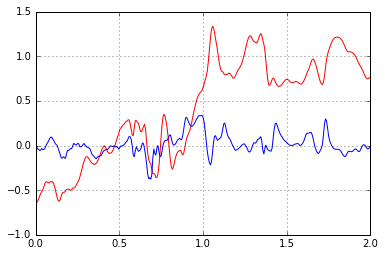

In [60]:
%%px
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

Y = np.linspace(0,2.*np.pi,Ny)
print(Y.shape)

if rank==0:
    plt.plot(Y,vx_xl,'r-')
    plt.plot(Y,vx_xldx/100,'b-')
    plt.grid()
    
    plt.xlim((0,2))
    
    plt.show()

[output:6]

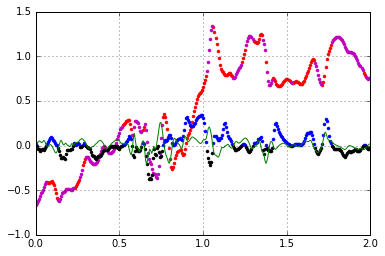

In [61]:
%%px 

if rank==0:
    pos = vx_xldx > 0
    neg = vx_xldx < 0
    
    dx = 2.*np.pi/1024
    vlgrx = np.gradient(vx_xl)/dx
    
    plt.plot(Y[pos],vx_xl[pos],'r.')
    plt.plot(Y[pos],vx_xldx[pos]/100,'b.')
    
    plt.plot(Y[neg],vx_xl[neg],'m.')
    plt.plot(Y[neg],vx_xldx[neg]/100,'k.')
    
    plt.plot(Y,vlgrx/100,'g')
    plt.grid()
    
    plt.xlim((0,2))
    
    plt.show()

[output:6]

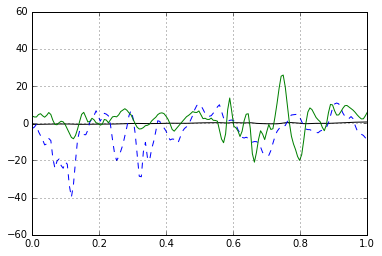

In [72]:
%%px 

if rank==0:
    pos = vx_zldx > 0
    neg = vx_zldx < 0
    
    dx = 2.*np.pi/1024
    vlgrx = np.gradient(vx_xl)/dx
    
    #plt.plot(Y[pos],vx_xl[pos],'r.')
    #plt.plot(Y[pos],vx_zldx[pos]/100,'b.')
    
    #plt.plot(Y[neg],vx_xl[neg],'m.')
    #plt.plot(Y[neg],vx_zldx[neg]/100,'k.')
    
    plt.plot(Y,vx_xl,'k')
    plt.plot(Y,vz_zldx,'b--')
    plt.plot(Y,vlgrx,'g')
    plt.grid()
    
    plt.xlim((0,1))
    
    plt.show()